In [5]:
import os 
import argparse
import numpy as np
import matplotlib.pyplot as plt
import numpy as np  
import cv2  
import face_alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)




In [40]:

import matplotlib.pyplot as plt

def SHOW(imagelist,figsize=None,savepath=None):
    num = len(imagelist)
    if figsize==None:
        plt.figure(figsize=(5*num,6))
    else:
        plt.figure(figsize=figsize)
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(imagelist[i],cv2.COLOR_BGR2RGB))
        
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()


def get_image_size(image):
    """
    获取图片大小（高度,宽度）
    :param image: image
    :return: （高度,宽度）
    """
    image_size = (image.shape[0], image.shape[1])
    return image_size


def get_face_landmarks(image, face_detector, shape_predictor):
    """
    获取人脸标志，68个特征点
    :param image: image
    :param face_detector: dlib.get_frontal_face_detector
    :param shape_predictor: dlib.shape_predictor
    :return: np.array([[],[]]), 68个特征点
    """
    dets = face_detector(image, 1)
    num_faces = len(dets)
    if num_faces == 0:
        print("Sorry, there were no faces found.")
        return None
    shape = shape_predictor(image, dets[0])
    face_landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return face_landmarks


def get_face_mask(image_size, face_landmarks):
    """
    获取人脸掩模
    :param image_size: 图片大小
    :param face_landmarks: 68个特征点
    :return: image_mask, 掩模图片
    """
    mask = np.zeros(image_size, dtype=np.uint8)
    points = np.concatenate([face_landmarks[0:16], face_landmarks[26:17:-1]])
    cv2.fillPoly(img=mask, pts=[points], color=255)

    # mask = np.zeros(image_size, dtype=np.uint8)
    # points = cv2.convexHull(face_landmarks)  # 凸包
    # cv2.fillConvexPoly(mask, points, color=255)
    return mask


def get_affine_image(image1, image2, face_landmarks1, face_landmarks2):
    """
    获取图片1仿射变换后的图片
    :param image1: 图片1, 要进行仿射变换的图片
    :param image2: 图片2, 只要用来获取图片大小，生成与之大小相同的仿射变换图片
    :param face_landmarks1: 图片1的人脸特征点
    :param face_landmarks2: 图片2的人脸特征点
    :return: 仿射变换后的图片
    """
    three_points_index = [18, 8, 25]
    M = cv2.getAffineTransform(face_landmarks1[three_points_index].astype(np.float32),
                               face_landmarks2[three_points_index].astype(np.float32))
    dsize = (image2.shape[1], image2.shape[0])
    affine_image = cv2.warpAffine(image1, M, dsize)
    return affine_image.astype(np.uint8)


def get_mask_center_point(image_mask):
    """
    获取掩模的中心点坐标
    :param image_mask: 掩模图片
    :return: 掩模中心
    """
    image_mask_index = np.argwhere(image_mask > 0)
    miny, minx = np.min(image_mask_index, axis=0)
    maxy, maxx = np.max(image_mask_index, axis=0)
    center_point = ((maxx + minx) // 2, (maxy + miny) // 2)
    return center_point


def get_mask_union(mask1, mask2):
    """
    获取两个掩模掩盖部分的并集
    :param mask1: mask_image, 掩模1
    :param mask2: mask_image, 掩模2
    :return: 两个掩模掩盖部分的并集
    """
    mask = np.min([mask1, mask2], axis=0)  # 掩盖部分并集
    mask = ((cv2.blur(mask, (5, 5)) == 255) * 255).astype(np.uint8)  # 缩小掩模大小
    mask = cv2.blur(mask, (3, 3)).astype(np.uint8)  # 模糊掩模
    return mask


def skin_color_adjustment(im1, im2, mask=None):
    """
    肤色调整
    :param im1: 图片1
    :param im2: 图片2
    :param mask: 人脸 mask. 如果存在，使用人脸部分均值来求肤色变换系数；否则，使用高斯模糊来求肤色变换系数
    :return: 根据图片2的颜色调整的图片1
    """
    if mask is None:
        im1_ksize = 55
        im2_ksize = 55
        im1_factor = cv2.GaussianBlur(im1, (im1_ksize, im1_ksize), 0).astype(np.float)
        im2_factor = cv2.GaussianBlur(im2, (im2_ksize, im2_ksize), 0).astype(np.float)
    else:
        im1_face_image = cv2.bitwise_and(im1, im1, mask=mask)
        im2_face_image = cv2.bitwise_and(im2, im2, mask=mask)
        im1_factor = np.mean(im1_face_image, axis=(0, 1))
        im2_factor = np.mean(im2_face_image, axis=(0, 1))

    im1 = np.clip((im1.astype(np.float) * im2_factor / np.clip(im1_factor, 1e-6, None)), 0, 255).astype(np.uint8)
    return im1





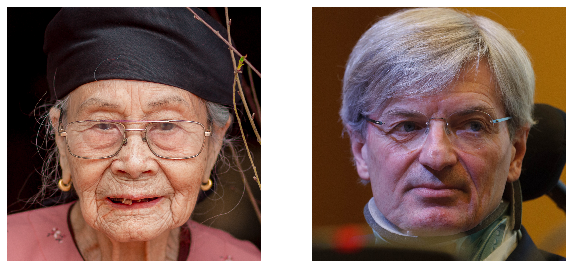

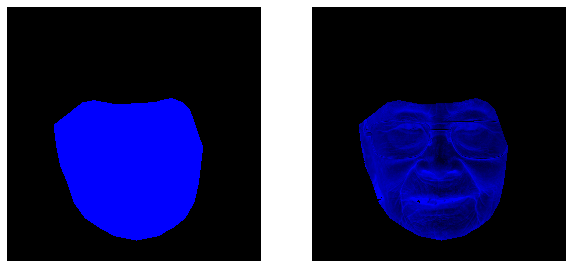

In [9]:
import os
import cv2
root = "/data/chengbin/ffhq-dataset/ffhq-lafin/images"
imagelists = os.listdir(root)

%matplotlib inline
import matplotlib.pyplot as plt

def SHOW(imagelist,figsize=None,savepath=None):
    num = len(imagelist)
    if figsize==None:
        plt.figure(figsize=(5*num,6))
    else:
        plt.figure(figsize=figsize)
    for i in range(num):
        plt.subplot(1,num,i+1)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(imagelist[i],cv2.COLOR_BGR2RGB))
        
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

id = (0,1)
ref_img = cv2.imread(os.path.join(root,imagelists[id[0]]))
tar_img = cv2.imread(os.path.join(root,imagelists[id[1]]))
SHOW([ref_img,tar_img])

from src.warp import get_face_mask
ref_landmark = fa.get_landmarks(ref_img)[0]
image_size = (input_img.shape[0], input_img.shape[1])  
ref_mask = get_face_mask(image_size,np.array(ref_landmark,dtype=np.int32))
SHOW([ref_mask,ref_mask*ref_img])


In [ ]:
from 

In [60]:
def swap_face(tar_img,ref_img):
    im2 = tar_img
    landmarks2 = np.array(fa.get_landmarks(tar_img)[0],dtype = np.int32)
    im1 = ref_img
    landmarks1 = np.array(fa.get_landmarks(ref_img)[0],dtype = np.int32)

    im1_size = get_image_size(im1)  
    im1_mask = get_face_mask(im1_size, landmarks1)  

    im2_size = get_image_size(im2)  
    im2_mask = get_face_mask(im2_size, landmarks2) 

    affine_im1 = get_affine_image(im1, im2, landmarks1, landmarks2)  
    affine_im1_mask = get_affine_image(im1_mask, im2, landmarks1, landmarks2)  

    union_mask = get_mask_union(im2_mask, affine_im1_mask)  

    affine_im1 = skin_color_adjustment(affine_im1, im2, mask=union_mask)  
    point = get_mask_center_point(affine_im1_mask)  
    seamless_im = cv2.seamlessClone(affine_im1, im2, mask=union_mask, p=point, flags=cv2.NORMAL_CLONE) 
    SHOW([affine_im1,im2,seamless_im])
    return seamless_im



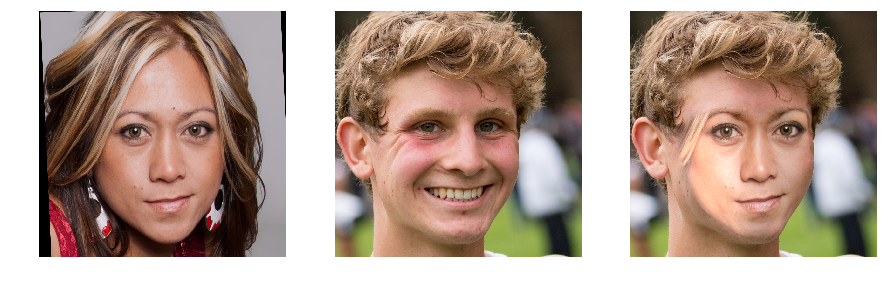

(1024, 1024, 3)


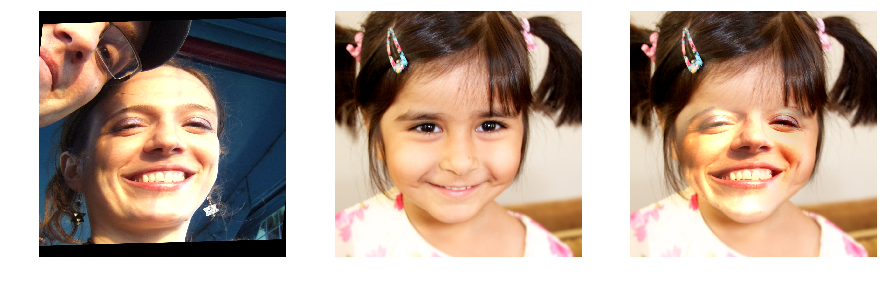

(1024, 1024, 3)


In [61]:
len_img = len(imagelists)
number = 10
for (i,j) in zip(np.random.choice(len_img,number),np.random.choice(len_img,number)):
    ref_img = cv2.imread(os.path.join(root,imagelists[i]))
    tar_img = cv2.imread(os.path.join(root,imagelists[j]))
    seamless_im = swap_face(ref_img,tar_img)
    print(seamless_im.shape)
    

In [4]:


ref_landmark = fa.get_landmarks(ref_img)[0]
ref_mask = get_face_mask(ref_img.shape,np.array(ref_landmark,dtype=np.int32))
SHOW([ref_mask*255,ref_mask*ref_img])



NameError: name &#39;fa&#39; is not defined

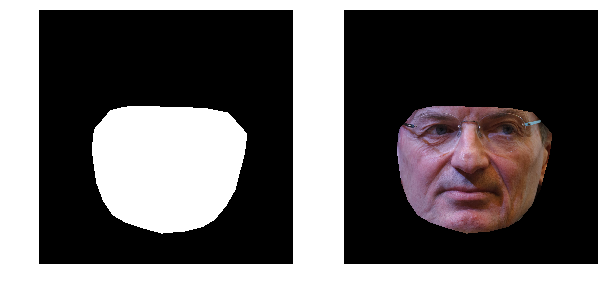

In [22]:
tar_landmark = fa.get_landmarks(tar_img)[0]
tar_mask = get_face_mask(tar_img.shape,np.array(tar_landmark,dtype=np.int32))
SHOW([tar_mask*255,tar_mask*tar_img])

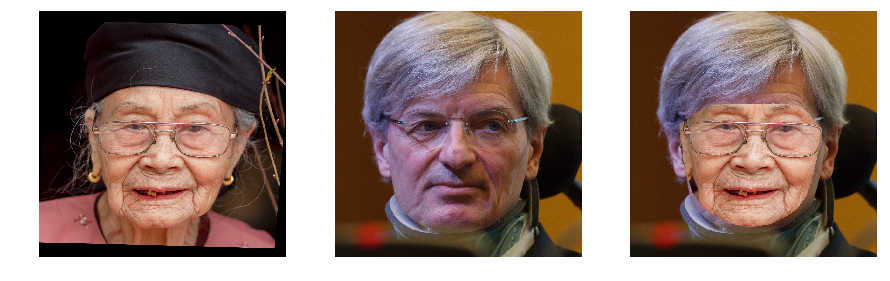

In [39]:

affine_im = get_affine_image(ref_img, tar_img, ref_landmark, tar_landmark)  
affine_im_mask = get_affine_image(ref_mask, tar_img, ref_landmark, tar_landmark)  
SHOW([affine_im,tar_img,affine_im*affine_im_mask+tar_img*(1-affine_im_mask)])


In [37]:


union_mask = get_mask_union(tar_mask, affine_im_mask)
affine_im = skin_color_adjustment(affine_im, tar_img, mask=union_mask)  

uint8 uint8
(1024, 1024, 3) (1024, 1024, 3)


error: OpenCV(4.1.2) /io/opencv/modules/core/src/arithm.cpp:245: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


In [71]:
affine_im.dtype, tar_img.dtype,union_mask.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'))

In [64]:
union_mask

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [50]:
union_mask

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [ ]:
point = get_mask_center_point(affine_im1_mask)  
seamless_im = cv2.seamlessClone(affine_im1, im2, mask=union_mask, p=point, flags=cv2.NORMAL_CLONE) 